In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [34]:
df = pd.read_csv('./data/100k_a.csv', names=['UserID', 'StreamID', 'StreamerUsername', 'Time start', 'Time stop'])
df['WatchDuration'] = (df['Time stop'] - df['Time start']) * 10 
df.head()

,UserID,StreamID,StreamerUsername,Time start,Time stop,WatchDuration
0,1,33842865744,mithrain,154,156,20
1,1,33846768288,alptv,166,169,30
2,1,33886469056,mithrain,587,588,10
3,1,33887624992,wtcn,589,591,20
4,1,33890145056,jrokezftw,591,594,30


## EDA

Start and stop times are provided as integers and represent periods of 10 minutes.

User ID (anonymized) /
Stream ID /
Streamer username /
Time start /
Time stop /

### basic statistics

In [35]:
# number of unique users
len(df['UserID'].unique())

100000

In [36]:
# number of unique streamers
len(df['StreamerUsername'].unique())

162625

In [37]:
# number of streams
len(df['StreamID'].unique())

739991

In [38]:
watchDuration = df.describe()['WatchDuration']

In [39]:
# interactions for users
userInteraction = df.groupby('UserID').size().describe()

In [40]:
# interactions for streamers
streamerInteraction = df.groupby('StreamerUsername').size().describe()

In [41]:
streamInteraction = df.groupby('StreamID').size().describe()

In [42]:
basicStatistics = pd.DataFrame([watchDuration, userInteraction, streamerInteraction, streamInteraction])
basicStatistics.index = ['Watch Duration (minutes)', 'User - num Interaction', 'Streamer - num Interaction', 'Stream - num Interaction']
basicStatistics

,count,mean,std,min,25%,50%,75%,max
Watch Duration (minutes),3051733.0,31.420544,42.579663,10.0,10.0,10.0,30.0,970.0
User - num Interaction,100000.0,30.517330,34.179094,5.0,8.0,16.0,39.0,327.0
Streamer - num Interaction,162625.0,18.765460,251.414758,1.0,1.0,2.0,5.0,45144.0
Stream - num Interaction,739991.0,4.124014,20.930964,1.0,1.0,1.0,2.0,2123.0


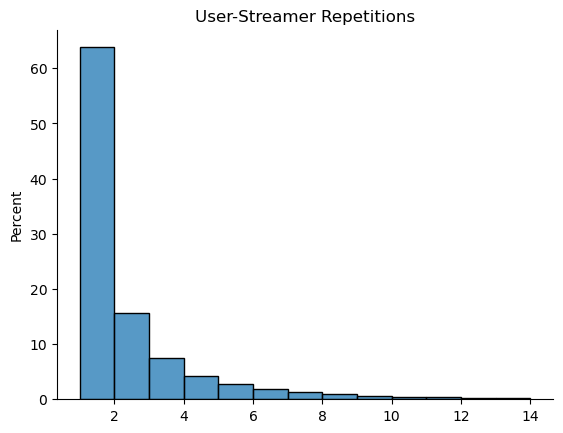

In [43]:
user_item_rep = df.groupby(['UserID', 'StreamerUsername']).size()
user_item_rep_plot = sns.histplot(user_item_rep, bins=range(1, 15), stat='percent')
user_item_rep_plot.set(title='User-Streamer Repetitions')
sns.despine()

In [44]:
pd.options.display.max_rows = 1000

In [45]:
user_item_rep.sort_values(ascending=False).iloc[:100]

UserID  StreamerUsername     
90511   vampresss                92
52872   luke4316live             90
2930    giannielee               82
93172   boerejongenstv           78
10780   luke4316live             63
68589   allkeyshop_tv            63
26467   estiny_tv                63
7944    team_brooks1213          62
99673   luke4316live             61
14224   redroyalestream          59
14493   u_heal                   52
71633   thefranchiselive         52
16063   barufplay                50
29666   homyatol                 50
69824   yogscast                 48
20774   van_hinten88             47
4674    digital_mousquetaires    47
11215   itermosifoni             47
11647   taezzang                 47
61243   gantver1                 45
68543   luke4316live             45
62052   yogscast                 44
14056   rubik2707                44
36755   giannielee               44
23083   redroyalestream          42
33862   elichtv                  42
97549   laznikoff                4

In [46]:
df.describe()

,UserID,StreamID,Time start,Time stop,WatchDuration
count,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06
mean,5.032313e+04,3.413002e+10,3.146044e+03,3.149186e+03,3.142054e+01
std,2.889476e+04,1.682242e+08,1.772520e+03,1.772656e+03,4.257966e+01
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+00,1.000000e+01
25%,2.528400e+04,3.398884e+10,1.618000e+03,1.620000e+03,1.000000e+01
50%,5.029900e+04,3.413069e+10,3.174000e+03,3.178000e+03,1.000000e+01
75%,7.545200e+04,3.427399e+10,4.676000e+03,4.679000e+03,3.000000e+01
max,1.000000e+05,3.441642e+10,6.147000e+03,6.148000e+03,9.700000e+02


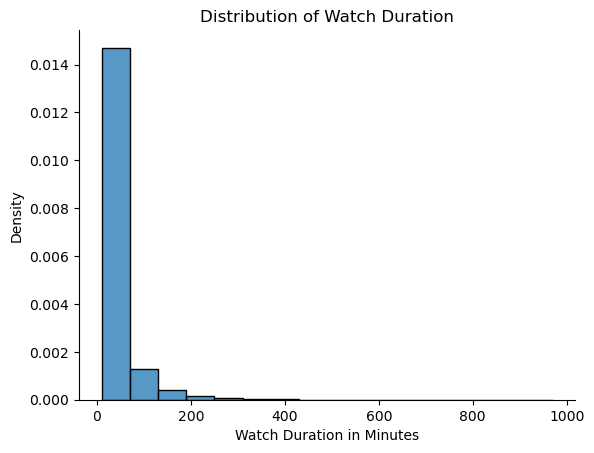

In [47]:
duration = sns.histplot(df, x='WatchDuration', bins=16, stat='density')
duration.set(xlabel='Watch Duration in Minutes', title='Distribution of Watch Duration')
sns.despine()

In [48]:
streamer_interactions = df.groupby('StreamerUsername').size().sort_values(ascending=False).reset_index(name='InteractionCount')
streamer_interactions

,StreamerUsername,InteractionCount
0,ninja,45144
1,tfue,40136
2,shroud,27362
3,riotgames,17633
4,sodapoppin,14590
...,...,...
162620,mrspajder,1
162621,mrsonderbar90,1
162622,daniel11420,1
162623,daniel2810_,1


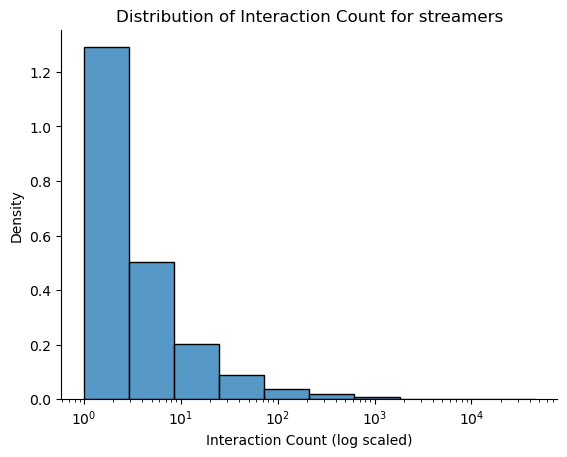

In [49]:
interaction = sns.histplot(streamer_interactions['InteractionCount'], bins=10, stat='density', log_scale=True)
interaction.set(xlabel='Interaction Count (log scaled)', title='Distribution of Interaction Count for streamers')
sns.despine()

In [50]:
# big stream avg watch duration vs mid vs small

...

Ellipsis

## Model

### Feature Extraction, Prepare data

In [51]:
train, test = train_test_split(df, test_size=0.3, random_state=158)

In [52]:
def feature_extraction(df):
    df = df.drop(columns=['Time start', 'Time stop'])
    # user features
    user_features = df.groupby('UserID').agg(
        UserAvgWatchDuration=('WatchDuration', 'mean'),
        NumWatchStream=('StreamID', 'count'),
        VarWatchStream=('WatchDuration', lambda x: x.var(ddof=0)) 
    ).reset_index()
    # streamer features
    streamer_features = df.groupby('StreamerUsername').agg(
        StreamerAvgWatchDuration=('WatchDuration', 'mean'),
        StreamerUniqueViewer=('UserID', 'nunique')
    ).reset_index()
    # user-streamer features
    user_streamer_features = df.groupby(['UserID', 'StreamID']).agg(
        UserStreamerWatchCount=('WatchDuration', 'count'),
        UserStreamerAvgWatchDuration=('WatchDuration', 'mean')
    ).reset_index()
    # stream features
    stream_features = df.groupby('StreamID').agg(
        StreamAvgWatchDuration=('WatchDuration', 'mean'),
        StreamUniqueViewer=('UserID', 'nunique')
    ).reset_index()
    df = (
        df
        .merge(user_features, on='UserID', how='left')
        .merge(streamer_features, on='StreamerUsername', how='left')
        .merge(user_streamer_features, on=['UserID', 'StreamID'], how='left')
        .merge(stream_features, on='StreamID', how='left')
    )
    return df

In [53]:
train = feature_extraction(train)
test = feature_extraction(test)

In [54]:
Xtrain, Ytrain = train.drop(columns='WatchDuration'), train['WatchDuration']
Xtest, Ytest = test.drop(columns='WatchDuration'), test['WatchDuration']

In [55]:
# encode StreamerUsername
streamer_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
streamer_encoder.fit(Xtrain[['StreamerUsername']])

Xtrain['StreamerUsername'] = streamer_encoder.transform(Xtrain[['StreamerUsername']])
Xtest['StreamerUsername'] = streamer_encoder.transform(Xtest[['StreamerUsername']])

### Baseline (always predict user mean)

In [56]:
# training set rmse
np.sqrt(mean_squared_error(Ytrain, Xtrain['UserAvgWatchDuration']))

38.565396425916525

In [57]:
# test set rmse
np.sqrt(mean_squared_error(Ytest, Xtest['UserAvgWatchDuration']))

37.40724564089123

### Decision Tree

In [58]:
dt = DecisionTreeRegressor(random_state=158)
dt.fit(Xtrain, Ytrain)

DecisionTreeRegressor(random_state=158)

In [59]:
# training mse
np.sqrt(mean_squared_error(dt.predict(Xtrain), Ytrain))

0.0

In [60]:
# test rmse
np.sqrt(mean_squared_error(dt.predict(Xtest), Ytest))

0.07536466165580678

### LightGBM

In [61]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(random_state=158)
lgbm.fit(Xtrain, Ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 2136213, number of used features: 11
[LightGBM] [Info] Start training from score 31.438040


LGBMRegressor(random_state=158)

In [62]:
# training rmse
np.sqrt(mean_squared_error(Ytrain, lgbm.predict(Xtrain)))

0.26776287189367287

In [63]:
# test rmse
np.sqrt(mean_squared_error(Ytest, lgbm.predict(Xtest)))

0.4754409556913325

## Random Forest

In [64]:
rf = RandomForestRegressor(n_estimators=100, random_state=158)
rf.fit(Xtrain, Ytrain)

RandomForestRegressor(random_state=158)

In [65]:
# training rmse
np.sqrt(mean_squared_error(Ytrain, lgbm.predict(Xtrain)))

0.26776287189367287

In [66]:
# test rmse
np.sqrt(mean_squared_error(Ytest, lgbm.predict(Xtest)))

0.4754409556913325

### Hyperparameter Tuning